# Train machine learning model to identify autophagy positive cells

In [1]:
import lamindb as ln
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import h5py

→ connected lamindb: scportrait/examples


In [2]:
# Define parameters for our RandomForest Classifier
ln.Param(name="random_state", dtype="int").save()
ln.Param(name="n_estimators", dtype="int").save()
ln.Param(name="max_depth", dtype="int").save()
ln.Param(name="min_samples_split", dtype="int").save()
ln.Param(name="min_samples_leaf", dtype="int").save()
ln.Param(name="max_features", dtype="str").save()
ln.Param(name="criterion", dtype="str").save()
ln.Param(name="bootstrap", dtype="bool").save()

# Define parameter values
rfc_params = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "criterion": "gini",
    "bootstrap": True,
}

ln.track(params=rfc_params)

→ returning existing Param record with same name: 'random_state'
→ returning existing Param record with same name: 'n_estimators'
→ returning existing Param record with same name: 'max_depth'
→ returning existing Param record with same name: 'min_samples_split'
→ returning existing Param record with same name: 'min_samples_leaf'
→ returning existing Param record with same name: 'max_features'
→ returning existing Param record with same name: 'criterion'
→ returning existing Param record with same name: 'bootstrap'
→ loaded Transform('siQQy6o49VMq0002'), re-started Run('p21u5tdn...') at 2025-03-05 15:36:52 UTC
→ params: random_state=42, n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, criterion=gini, bootstrap=True
→ notebook imports: h5py==3.13.0 lamindb==1.1.1 matplotlib==3.10.0 pandas==2.2.3 scikit-learn==1.5.2


Our aim is to be able to distinguish autophagy-positive from autophagy-negative cells. As we can see visually by looking at a few exmaple images the cells look very distinct. Goal of this notebook is to train a ML model to distininguish these two classes of cells from one another based on our pre-calculated image features which try to condense the information contained in the single-cell images into meaningful features.

In [3]:
study = ln.ULabel.get(name="autophagy imaging")

sc_datasets = ln.Artifact.filter(ulabels=study).filter(
    ulabels__name="scportrait single-cell images"
)
featurized_datasets = ln.Artifact.filter(ulabels=study).filter(
    ulabels__name="single-cell image featurization results"
)

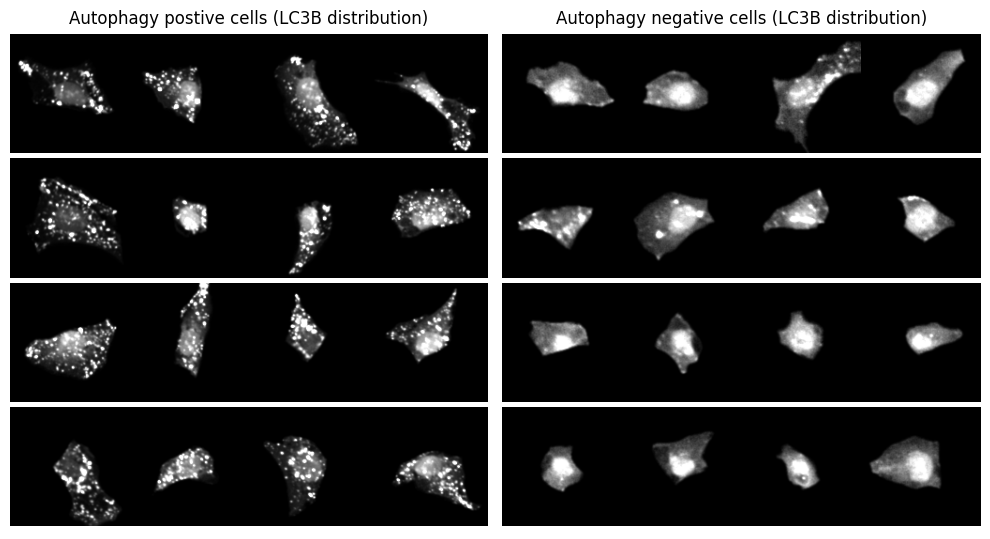

In [4]:
# get example images for positive and negative autophagy
num_rows, num_cols = 4, 4
n_cells = num_rows * num_cols
channel_of_interest = 4 # LC3B channel a key autophagosome marker

autophagy_positive_example = sc_datasets.filter(ulabels__name="WT").filter(ulabels__name="14h Torin-1")[0]
with h5py.File(autophagy_positive_example.cache(), 'r') as hf:
    images_panel1 =hf["single_cell_data"][0:n_cells, channel_of_interest]

autophagy_negative_example = sc_datasets.filter(ulabels__name="WT").filter(ulabels__name="untreated")[0]
with h5py.File(autophagy_negative_example.cache(), 'r') as hf:
    images_panel2 =hf["single_cell_data"][0:n_cells, channel_of_interest]

# create a figure with two panels for negative and postiive examples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5.5))

def plot_image_grid(ax, images, num_rows, num_cols, title):
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    for i, img in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        ax_sub = ax.inset_axes([(col / num_cols), (1 - (row + 1) / num_rows), 
                                (1 / num_cols), (1 / num_rows)])
        ax_sub.imshow(img, cmap='gray', vmin = 0, vmax = 1)
        ax_sub.axis('off')

plot_image_grid(axes[0], images_panel1, num_rows, num_cols, title = "Autophagy postive cells (LC3B distribution)")
plot_image_grid(axes[1], images_panel2, num_rows, num_cols, title = "Autophagy negative cells (LC3B distribution)")
fig.tight_layout()



Get the `wildtype` and `EI24KO` KO features:

In [5]:
# load data
wt_cells_afs = featurized_datasets.filter(ulabels__name="WT").distinct().one()
features_wt = wt_cells_afs.load()

ko_cells_afs = featurized_datasets.filter(ulabels__name="EI24KO").distinct().one()
features_ko = ko_cells_afs.load()

In [7]:
# Remove columns we don't want to train on
data = features_wt.drop(columns=["dataset", "cell_id"])
data = data.drop(columns=[col for col in data.columns if "mCherry" in col]) # subset to only include features from our channel of interest

# Separate features and target
X = data.drop("class", axis=1)
y = data["class"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# TODO can or should we use https://docs.lamin.ai/lamindb.core.mappedcollection (https://docs.lamin.ai/scrna-mappedcollection)

# Train model
clf = RandomForestClassifier(**rfc_params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Accuracy: 0.6929824561403509
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.30      0.43        43
           1       0.69      0.93      0.79        71

    accuracy                           0.69       114
   macro avg       0.70      0.62      0.61       114
weighted avg       0.70      0.69      0.65       114



TODO 1-3 takeaway sentences

In [9]:
data_ko = features_ko.drop(columns=["dataset", "cell_id"])
data_ko = data_ko.drop(columns=[x for x in data_ko.columns if "mCherry" in x])
X_ko = data_ko.drop("class", axis=1)
y_true = data_ko["class"]
predictions_ko = clf.predict(X_ko)

In [10]:
pred_results = pd.DataFrame({"prediction": predictions_ko, "label": y_true})

In [11]:
pred_results[pred_results.label == 0].sum() / pred_results[
    pred_results.label == 0
].count()

prediction    0.711911
label         0.000000
dtype: float64

TODO add 1-3 takeaway sentences

In [12]:
ln.finish()

• please hit CMD + s to save the notebook in your editor . ✓
! cells [(5, 7), (7, 9)] were not run consecutively
→ finished Run('p21u5tdn') after 1m at 2025-03-05 15:38:35 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/siQQy6o49VMq0002
→ to update your notebook from the CLI, run: lamin save /Users/sophia/Documents/GitHub/lamin-usecases/docs/imaging4.ipynb
